In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import Sequence
import cv2
import matplotlib.pyplot as plt

img_size = 224

def load_data(IMAGES_PATH, annotations):
    images = []
    gaze_labels = []
    
    for index, row in annotations.iterrows():
        
            img_path = os.path.join(IMAGES_PATH, row[0])
            image = cv2.imread(img_path)
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = image / 255.0

            x1, y1, x2, y2 = row[2], row[3], row[4], row[5]
            xx1, yy1, xx2, yy2 = row[6], row[7], row[8], row[9]

            image_left = image[y1:y2, x1:x2]
            image_right = image[yy1:yy2, xx1:xx2]
            
            imageLeft_resized = cv2.resize(image_left, (img_size, img_size))
            imageRight_resized = cv2.resize(image_right, (img_size, img_size))

            images.append([imageLeft_resized, imageRight_resized])
            
            label = row[1]
            
            if label < -1:
                gaze_labels.append('left')
            elif label > 1:
                gaze_labels.append('right')
            else:
                gaze_labels.append('center')   
            
    return np.array(images), np.array(gaze_labels)

annotations1 = pd.read_csv('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet/_annotations.csv')
X, Y = load_data('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet', annotations1)

/tmp/ipykernel_672/3470182985.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(IMAGES_PATH, row[0])
/tmp/ipykernel_672/3470182985.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[2], row[3], row[4], row[5]
/tmp/ipykernel_672/3470182985.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx1, yy1, xx2, yy2 = row[6], row[7], row[8], row[9]
/tmp/ipykernel_672/3470182985.py:37: Futur

In [2]:
X = np.expand_dims(X, -1)

X = np.repeat(X, 3, axis=-1)

In [3]:
X.shape

(3196, 2, 224, 224, 3)

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_class_flat = label_encoder.fit_transform(Y.flatten())
y_train_class_encoded = to_categorical(y_train_class_flat)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y_train_class_encoded, test_size=0.3, shuffle=True, random_state=42)

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.models import clone_model

img_size = 224

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False


input_1 = layers.Input(shape=(img_size, img_size, 3))
input_2 = layers.Input(shape=(img_size, img_size, 3))

features_1 = base_model(input_1)
features_2 = base_model(input_2)

combined_features = layers.Concatenate()([features_1, features_2])

x = layers.Conv2D(64, (8,8), activation='relu', padding='same')(combined_features)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (8,8), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (8,8), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

output_layer = layers.Dense(3, activation='softmax', name='output')(x)

model = models.Model(inputs=[input_1, input_2], outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7,      │          0 │ mobilenetv2_1.00… │
│ (Concatenate)       │ 2560)             │            │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 64)  │ 10,485,824 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │    524,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 3, 3, 128) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3, 3, 128) │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 256) │  2,097,408 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 256) │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 1, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 1, 256) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        771 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,434,499 (58.88 MB)

 Trainable params: 13,175,363 (50.26 MB)

 Non-trainable params: 2,259,136 (8.62 MB)

In [8]:
X_train_1 = X_train[:, 0, :, :, :]
X_train_2 = X_train[:, 1, :, :, :]

X_test_1 = X_test[:, 0, :, :, :]
X_test_2 = X_test[:, 1, :, :, :]

In [9]:
history = model.fit([X_train_1, X_train_2], Y_train, epochs=10, 
                    validation_data=([X_test_1, X_test_2], Y_test), verbose=1, batch_size=16)

Epoch 1/10


I0000 00:00:1733283500.207844     712 service.cc:145] XLA service 0x7df1d4002420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733283500.207926     712 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/140 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4021 - loss: 1.4402 

I0000 00:00:1733283511.113045     712 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 201ms/step - accuracy: 0.3742 - loss: 1.5747 - val_accuracy: 0.6778 - val_loss: 0.8605
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6250 - loss: 0.9319 - val_accuracy: 0.5266 - val_loss: 1.7228
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7601 - loss: 0.6204 - val_accuracy: 0.7946 - val_loss: 0.5186
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7959 - loss: 0.5202 - val_accuracy: 0.7862 - val_loss: 0.5117
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8278 - loss: 0.4392 - val_accuracy: 0.8133 - val_loss: 0.4852
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8593 - loss: 0.3473 - val_accuracy: 0.6955 - val_loss: 0.8553
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8713 - loss: 0.3384 - val_accuracy: 0.7643 - val_loss: 0.6707
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8789 - loss: 0.2920 - val_accuracy: 0.7

In [10]:
model.save('model_gaze_3.h5')

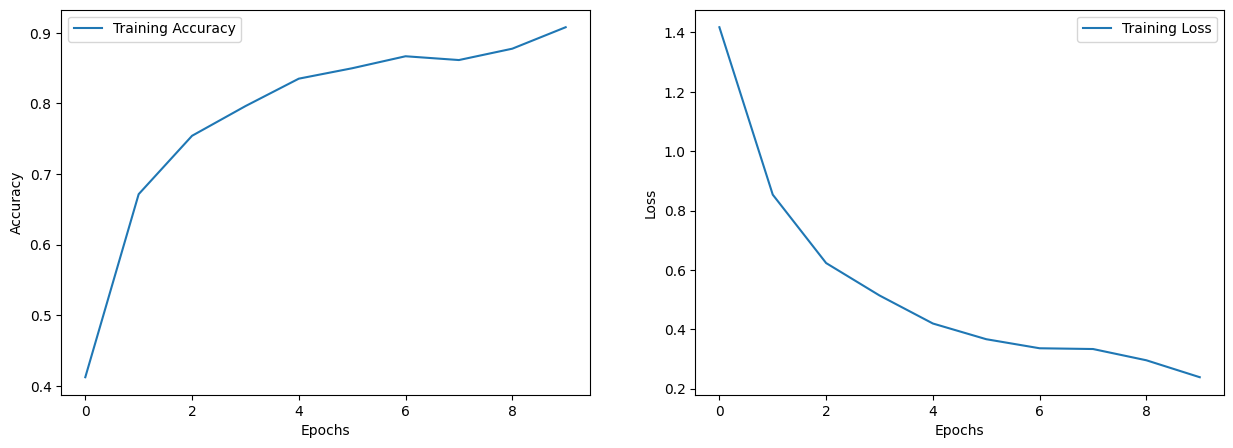

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()